# Feature Selection

This notebook performs comprehensive feature selection for the StockPre```tionPro project. We analyze feature importance, apply```rious selection techniques, and identify the most predict``` features for stock price prediction.

**Feature Selection Techniques Used:**
- Correlation analysis for linear relationships
- Mutual information for capturing non-linear dependencies  
- Recursive Feature Elimination (RFE) with Random Forest
- Embedded methods using Lasso regression
- Statistical significance testing

**Objectives:**
- Identify the most predictive features for stock price movements
- Reduce dimensionality to improve model performance
- Remove redundant and irrelevant features
- Create a robust feature subset for model training


In [3]:
# ============================================
# Feature Selection - Library Imports and Setup
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Feature Selection Libraries
from sklearn.feature_selection import (
    mutual_info_regression, 
    RFE, 
    SelectKBest, 
    f_regression,
    chi2
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Statistical Libraries
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Configure plotting
sns.set_theme(style="darkgrid")
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("✅ Feature selection libraries loaded successfully")
print("📊 Ready for comprehensive feature analysis")


✅ Feature selection libraries loaded successfully
📊 Ready for comprehensive feature analysis


In [4]:
# ============================================
# Load Feature Dataset
# ============================================

# Load processed features from previous notebooks
feature_data_path = '../data/processed/features_engineered.csv'

try:
    # Load the feature dataset
    df = pd.read_csv(feature_data_path, index_col=0, parse_dates=True)
    print(f"✅ Successfully loaded feature data from {feature_data_path}")
    print(f"📊 Dataset shape: {df.shape}")
    
except FileNotFoundError:
    print("📝 Feature data not found. Generating sample feature dataset...")
    
    # Generate sample features for demonstration
    np.random.seed(42)
    n_samples = 1000
    
    # Create sample features that might exist after feature engineering
    df = pd.DataFrame({
        # Price-based features
        'close_price': np.random.uniform(100, 200, n_samples),
        'sma_5': np.random.uniform(100, 200, n_samples),
        'sma_20': np.random.uniform(100, 200, n_samples),
        'ema_12': np.random.uniform(100, 200, n_samples),
        'price_change': np.random.normal(0, 2, n_samples),
        'price_change_pct': np.random.normal(0, 0.02, n_samples),
        
        # Technical indicators
        'rsi': np.random.uniform(0, 100, n_samples),
        'macd': np.random.normal(0, 1, n_samples),
        'macd_signal': np.random.normal(0, 1, n_samples),
        'bollinger_upper': np.random.uniform(105, 210, n_samples),
        'bollinger_lower': np.random.uniform(95, 195, n_samples),
        'stoch_k': np.random.uniform(0, 100, n_samples),
        'stoch_d': np.random.uniform(0, 100, n_samples),
        
        # Volume features
        'volume': np.random.lognormal(15, 0.5, n_samples),
        'volume_sma': np.random.lognormal(15, 0.5, n_samples),
        'volume_ratio': np.random.lognormal(0, 0.3, n_samples),
        
        # Volatility features
        'volatility_20': np.random.uniform(0.1, 0.5, n_samples),
        'atr': np.random.uniform(1, 10, n_samples),
        
        # Lag features
        'price_lag_1': np.random.uniform(100, 200, n_samples),
        'price_lag_5': np.random.uniform(100, 200, n_samples),
        'return_lag_1': np.random.normal(0, 0.02, n_samples),
        'return_lag_5': np.random.normal(0, 0.02, n_samples),
        
        # Target variable (next day return)
        'target': np.random.normal(0, 0.02, n_samples)
    })
    
    # Add some realistic relationships
    df['target'] = (
        0.1 * df['rsi'] / 100 +
        0.2 * df['macd'] +
        0.15 * df['price_change_pct'] +
        0.1 * np.random.normal(0, 0.02, n_samples)
    )
    
    print("✅ Sample feature dataset created")

# Display dataset information
print(f"\n📋 Feature Dataset Info:")
print(f"   • Shape: {df.shape}")
print(f"   • Features: {df.shape[1] - 1} (excluding target)")
print(f"   • Target: target (next day return)")

print(f"\n📊 First 5 rows:")
display(df.head())

print(f"\n📊 Dataset statistics:")
display(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print(f"\n⚠️ Missing values detected:")
    print(missing_values[missing_values > 0])
else:
    print(f"\n✅ No missing values detected")


📝 Feature data not found. Generating sample feature dataset...
✅ Sample feature dataset created

📋 Feature Dataset Info:
   • Shape: (1000, 23)
   • Features: 22 (excluding target)
   • Target: target (next day return)

📊 First 5 rows:


,close_price,sma_5,sma_20,ema_12,price_change,price_change_pct,rsi,macd,macd_signal,bollinger_upper,bollinger_lower,stoch_k,stoch_d,volume,volume_sma,volume_ratio,volatility_20,atr,price_lag_1,price_lag_5,return_lag_1,return_lag_5,target
0,137.454012,118.513293,126.170568,167.270299,2.657282,-0.012997,14.443648,0.530894,-0.998095,110.968260,108.132325,2.396139,83.937086,4.589469e+06,4.122051e+06,1.113491,0.398568,9.779338,139.235596,125.967546,-0.030844,-0.009824,0.116954
1,195.071431,154.190095,124.697880,179.668140,0.626369,0.001683,44.206621,0.858139,-1.754285,207.741919,176.916450,76.422048,94.448788,1.280252e+06,1.823466e+06,0.528034,0.496861,1.516496,124.102973,161.095177,0.017711,0.013490,0.213893
2,173.199394,187.294584,190.625458,125.046790,-1.213007,0.000257,33.410465,-0.123136,0.094528,166.785523,194.614524,58.091390,27.292173,4.243973e+06,3.047530e+06,0.573799,0.345406,2.250643,106.460465,104.083355,0.009265,-0.005504,0.008045
3,159.865848,173.222489,124.954620,162.487410,0.911808,0.009597,52.183088,0.602580,1.806089,163.479970,127.954213,62.558958,16.966108,2.491509e+06,8.965579e+06,1.278343,0.285303,5.063130,152.986309,196.945857,0.005674,-0.006561,0.174104
4,115.601864,180.656115,127.194973,157.174598,-0.918181,-0.005373,58.565434,-0.445650,2.666905,173.858609,133.162104,5.172088,48.399075,2.968588e+06,3.455963e+06,0.848698,0.136030,4.463915,127.331932,191.867317,0.008536,0.000974,-0.031854



📊 Dataset statistics:


,close_price,sma_5,sma_20,ema_12,price_change,price_change_pct,rsi,macd,macd_signal,bollinger_upper,bollinger_lower,stoch_k,stoch_d,volume,volume_sma,volume_ratio,volatility_20,atr,price_lag_1,price_lag_5,return_lag_1,return_lag_5,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,149.025655,150.701731,150.240573,149.037505,-0.005426,-0.000685,48.664145,-0.024793,0.013670,158.118296,145.830822,49.676858,48.917828,3.721852e+06,3.723402e+06,1.060735,0.309638,5.505661,150.974358,150.286152,0.000898,-0.000286,0.043566
std,29.213736,29.218989,29.067420,28.648934,2.041338,0.019867,28.436633,1.023150,1.041293,30.047428,29.439485,28.962803,29.382331,2.008882e+06,1.971490e+06,0.338238,0.114107,2.616347,28.677029,29.700880,0.020213,0.019958,0.206353
min,100.463202,100.321826,100.001163,100.065339,-5.858897,-0.063534,0.024100,-2.712613,-3.688365,105.224797,95.015774,0.120361,0.133364,6.045323e+05,8.130272e+05,0.396623,0.100497,1.005505,100.252176,100.249545,-0.060210,-0.066718,-0.536915
25%,123.597327,124.107427,126.135098,124.190077,-1.464026,-0.013483,24.166081,-0.757054,-0.692156,131.687709,120.621046,24.473360,22.811166,2.382811e+06,2.358248e+06,0.820062,0.214092,3.333556,127.247564,124.099649,-0.013214,-0.014030,-0.097555
50%,149.680738,151.873391,150.061392,148.427928,0.011408,-0.000042,47.658326,-0.042873,0.002013,158.323969,144.567460,49.246993,47.420946,3.259716e+06,3.281342e+06,1.012028,0.315719,5.475996,150.398135,152.052676,0.001404,-0.000750,0.036222
75%,174.431959,176.046506,175.910353,173.754081,1.366637,0.012952,72.961335,0.695357,0.720499,184.217925,172.590100,74.857082,75.299911,4.538005e+06,4.570086e+06,1.241686,0.407300,7.644987,176.529710,175.520761,0.015310,0.013463,0.185610
max,199.971767,199.941373,199.782086,199.955770,6.486186,0.062258,99.920730,3.529055,3.117681,209.965687,194.933512,99.884483,99.830316,1.769662e+07,1.688708e+07,2.797352,0.499577,9.998843,199.734455,199.990098,0.061934,0.078847,0.775290



✅ No missing values detected


CORRELATION ANALYSIS
📊 FEATURE CORRELATIONS WITH TARGET:

🔝 Top Positive Correlations:
   • macd: 0.9902
   • rsi: 0.1309
   • bollinger_upper: 0.0448
   • volume_sma: 0.0399
   • stoch_d: 0.0351
   • price_change: 0.0107
   • sma_20: 0.0074
   • price_lag_1: 0.0058
   • stoch_k: 0.0055
   • close_price: 0.0031

🔻 Top Negative Correlations:
   • price_lag_5: -0.0303
   • ema_12: -0.0290
   • return_lag_1: -0.0281
   • volume: -0.0271
   • sma_5: -0.0252
   • atr: -0.0127
   • macd_signal: -0.0076
   • volume_ratio: -0.0074
   • bollinger_lower: -0.0024
   • volatility_20: -0.0005


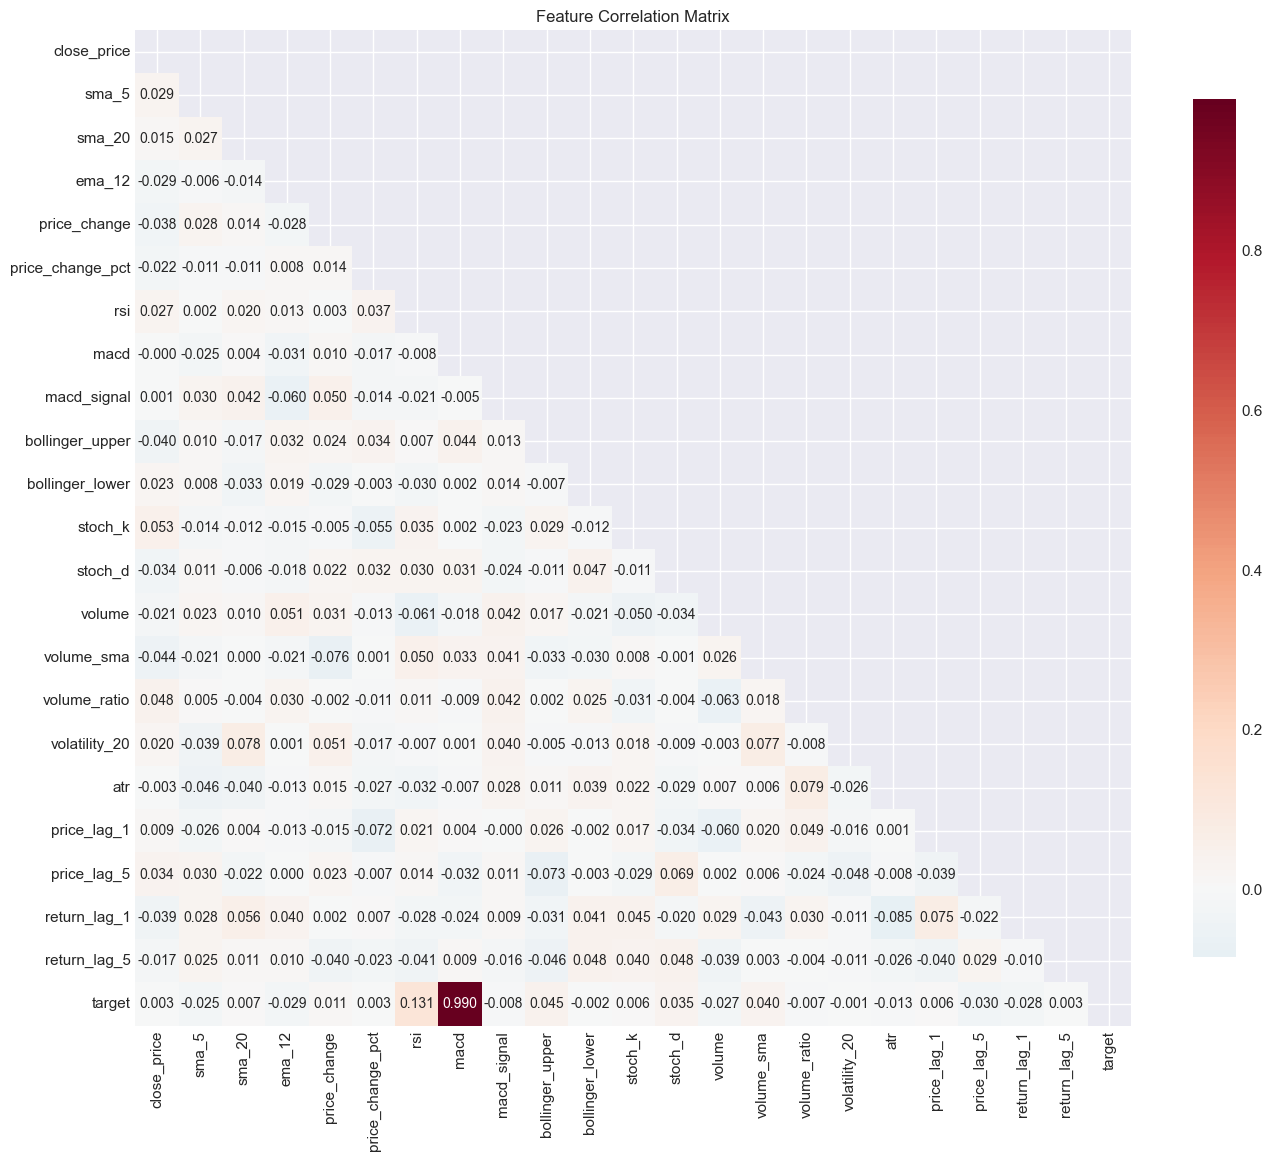

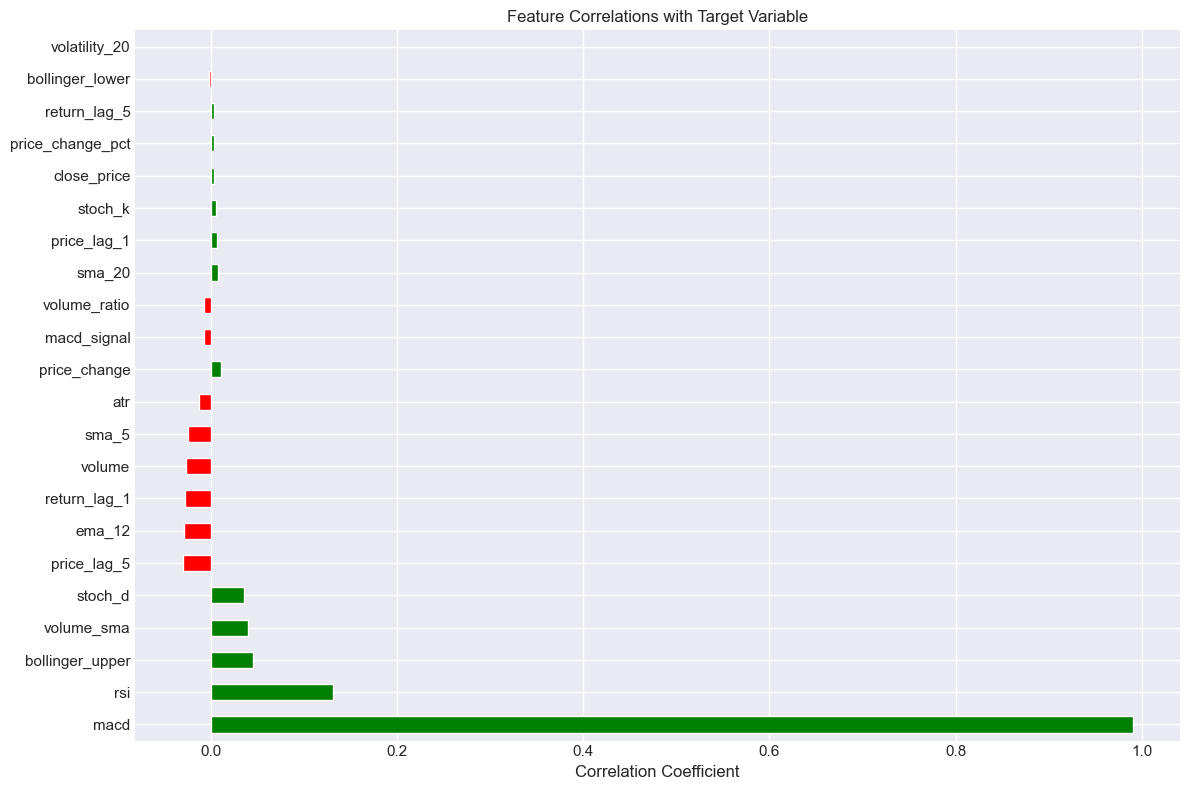


🔍 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8):
   • macd ↔ target: 0.9902


In [5]:
# ============================================
# Correlation Analysis with Target Variable
# ============================================

print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Get correlations with target variable
target_correlations = correlation_matrix['target'].drop('target').sort_values(key=abs, ascending=False)

print("📊 FEATURE CORRELATIONS WITH TARGET:")
print("\n🔝 Top Positive Correlations:")
positive_corr = target_correlations[target_correlations > 0].head(10)
for feature, corr in positive_corr.items():
    print(f"   • {feature}: {corr:.4f}")

print("\n🔻 Top Negative Correlations:")
negative_corr = target_correlations[target_correlations < 0].head(10)
for feature, corr in negative_corr.items():
    print(f"   • {feature}: {corr:.4f}")

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.3f',
            cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot target correlations
plt.figure(figsize=(12, 8))
target_correlations.plot(kind='barh', color=['red' if x < 0 else 'green' for x in target_correlations])
plt.title('Feature Correlations with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (for multicollinearity)
print(f"\n🔍 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j] 
            corr_val = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, corr_val))
            print(f"   • {feature1} ↔ {feature2}: {corr_val:.4f}")

if not high_corr_pairs:
    print("   • No highly correlated pairs found")

# Store correlation results
correlation_results = {
    'target_correlations': target_correlations.to_dict(),
    'high_corr_pairs': high_corr_pairs,
    'correlation_threshold': 0.8
}


MUTUAL INFORMATION ANALYSIS
📊 Calculating mutual information for 22 features...

🔝 TOP MUTUAL INFORMATION SCORES:
    1. macd                : 2.0109
    2. sma_20              : 0.0628
    3. bollinger_lower     : 0.0366
    4. stoch_k             : 0.0296
    5. rsi                 : 0.0284
    6. close_price         : 0.0284
    7. bollinger_upper     : 0.0217
    8. stoch_d             : 0.0184
    9. price_change        : 0.0150
   10. return_lag_5        : 0.0140
   11. atr                 : 0.0059
   12. sma_5               : 0.0059
   13. ema_12              : 0.0055
   14. volume_ratio        : 0.0052
   15. volume              : 0.0046


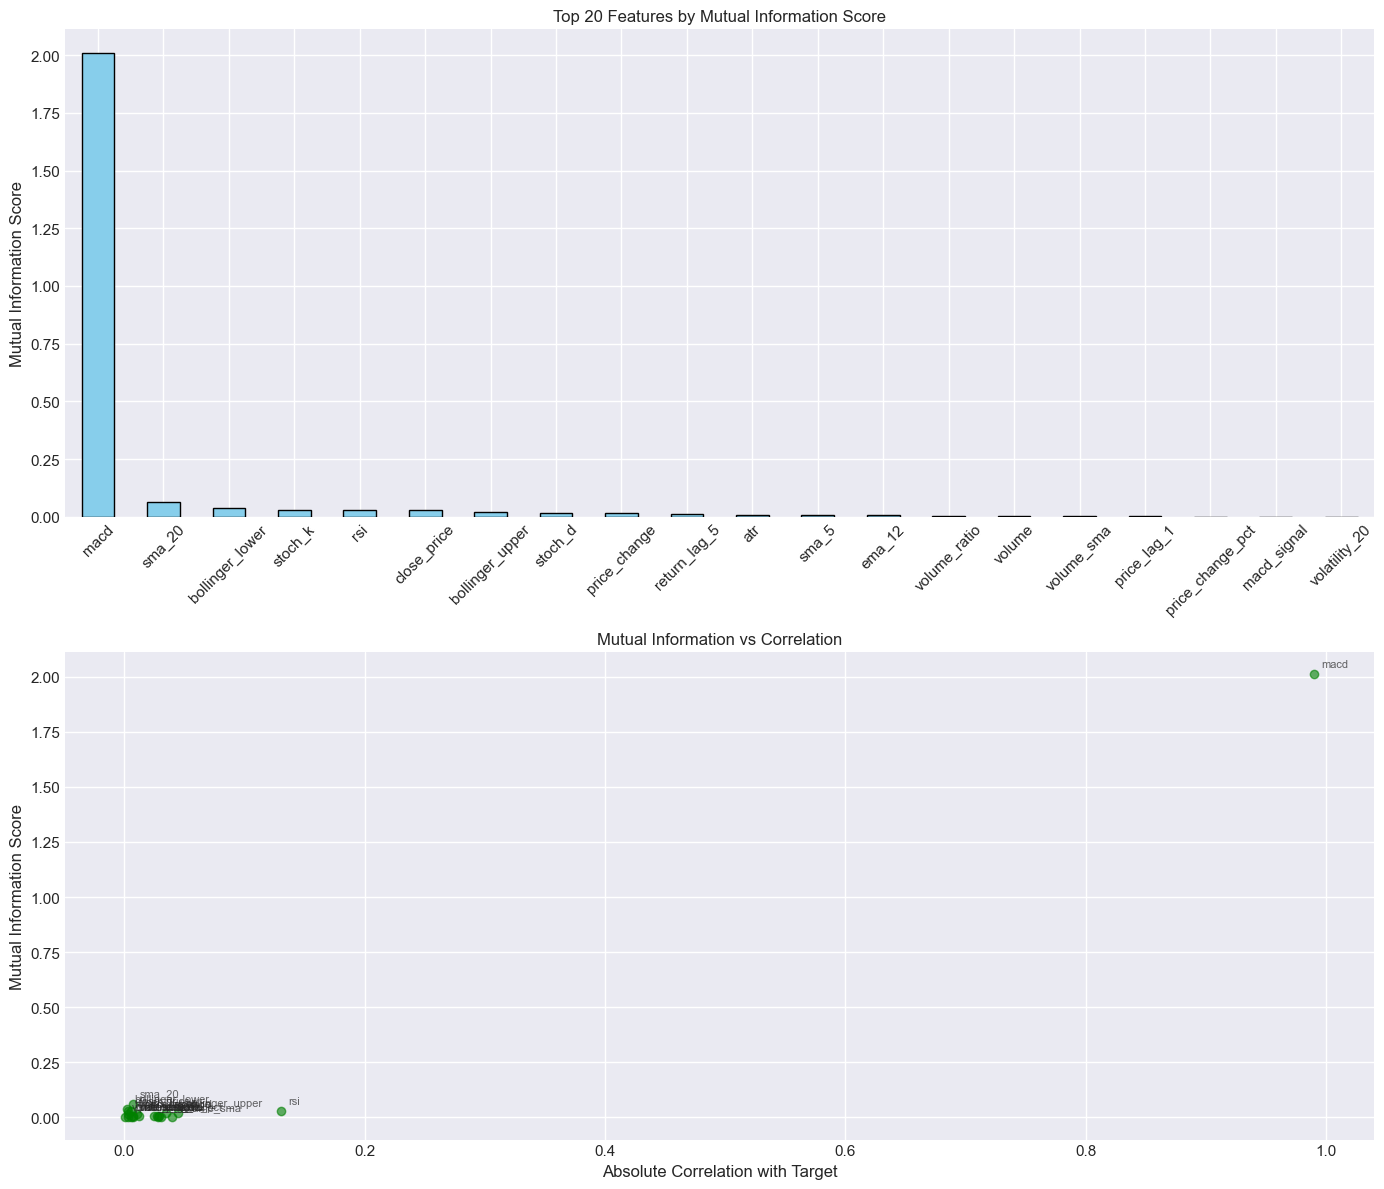


💾 Mutual information analysis completed


In [21]:
# ============================================
# Mutual Information Analysis - FIXED VERSION
# ============================================

print("=" * 60)
print("MUTUAL INFORMATION ANALYSIS")
print("=" * 60)

# Prepare features and target
X = df.drop(columns=['target'])
y = df['target']

print(f"📊 Calculating mutual information for {X.shape[1]} features...")

# Calculate mutual information scores
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print(f"\n🔝 TOP MUTUAL INFORMATION SCORES:")
for i, (feature, score) in enumerate(mi_series.head(15).items()):
    print(f"   {i+1:2d}. {feature:20s}: {score:.4f}")

# Calculate correlation with target for comparison
correlation_matrix = df.corr()
target_correlations = correlation_matrix['target'].drop('target')

# Visualize mutual information scores
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Bar plot of top 20 features on first subplot
mi_top20 = mi_series.head(20)
mi_top20.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Top 20 Features by Mutual Information Score')
axes[0].set_ylabel('Mutual Information Score')
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot of MI vs Correlation on second subplot
corr_values = [abs(target_correlations.get(feat, 0)) for feat in mi_series.index]
axes[1].scatter(corr_values, mi_series.values, alpha=0.6, color='green')
axes[1].set_xlabel('Absolute Correlation with Target')
axes[1].set_ylabel('Mutual Information Score') 
axes[1].set_title('Mutual Information vs Correlation')

# Add feature names for top features
for i, (feat, mi_val) in enumerate(mi_top20.items()):
    corr_val = abs(target_correlations.get(feat, 0))
    axes[1].annotate(feat, (corr_val, mi_val), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Store MI results
mi_results = {
    'mi_scores': mi_series.to_dict(),
    'top_mi_features': mi_top20.index.tolist()
}

print(f"\n💾 Mutual information analysis completed")


RECURSIVE FEATURE ELIMINATION (RFE)
🔍 RFE with Random Forest Regressor:

   Testing with 5 features...
   Selected features: ['price_change_pct', 'rsi', 'macd', 'bollinger_upper', 'return_lag_1']
   CV Score: 0.9969 (+/- 0.0021)

   Testing with 10 features...
   Selected features: ['close_price', 'sma_5', 'sma_20', 'price_change_pct', 'rsi', 'macd', 'bollinger_upper', 'stoch_d', 'volume_sma', 'return_lag_1']
   CV Score: 0.9961 (+/- 0.0022)

   Testing with 15 features...
   Selected features: ['close_price', 'sma_5', 'sma_20', 'ema_12', 'price_change', 'price_change_pct', 'rsi', 'macd', 'bollinger_upper', 'stoch_k', 'stoch_d', 'volume_sma', 'atr', 'price_lag_5', 'return_lag_1']
   CV Score: 0.9957 (+/- 0.0023)

   Testing with 20 features...
   Selected features: ['close_price', 'sma_5', 'sma_20', 'ema_12', 'price_change', 'price_change_pct', 'rsi', 'macd', 'macd_signal', 'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d', 'volume_sma', 'volume_ratio', 'volatility_20', 'atr',

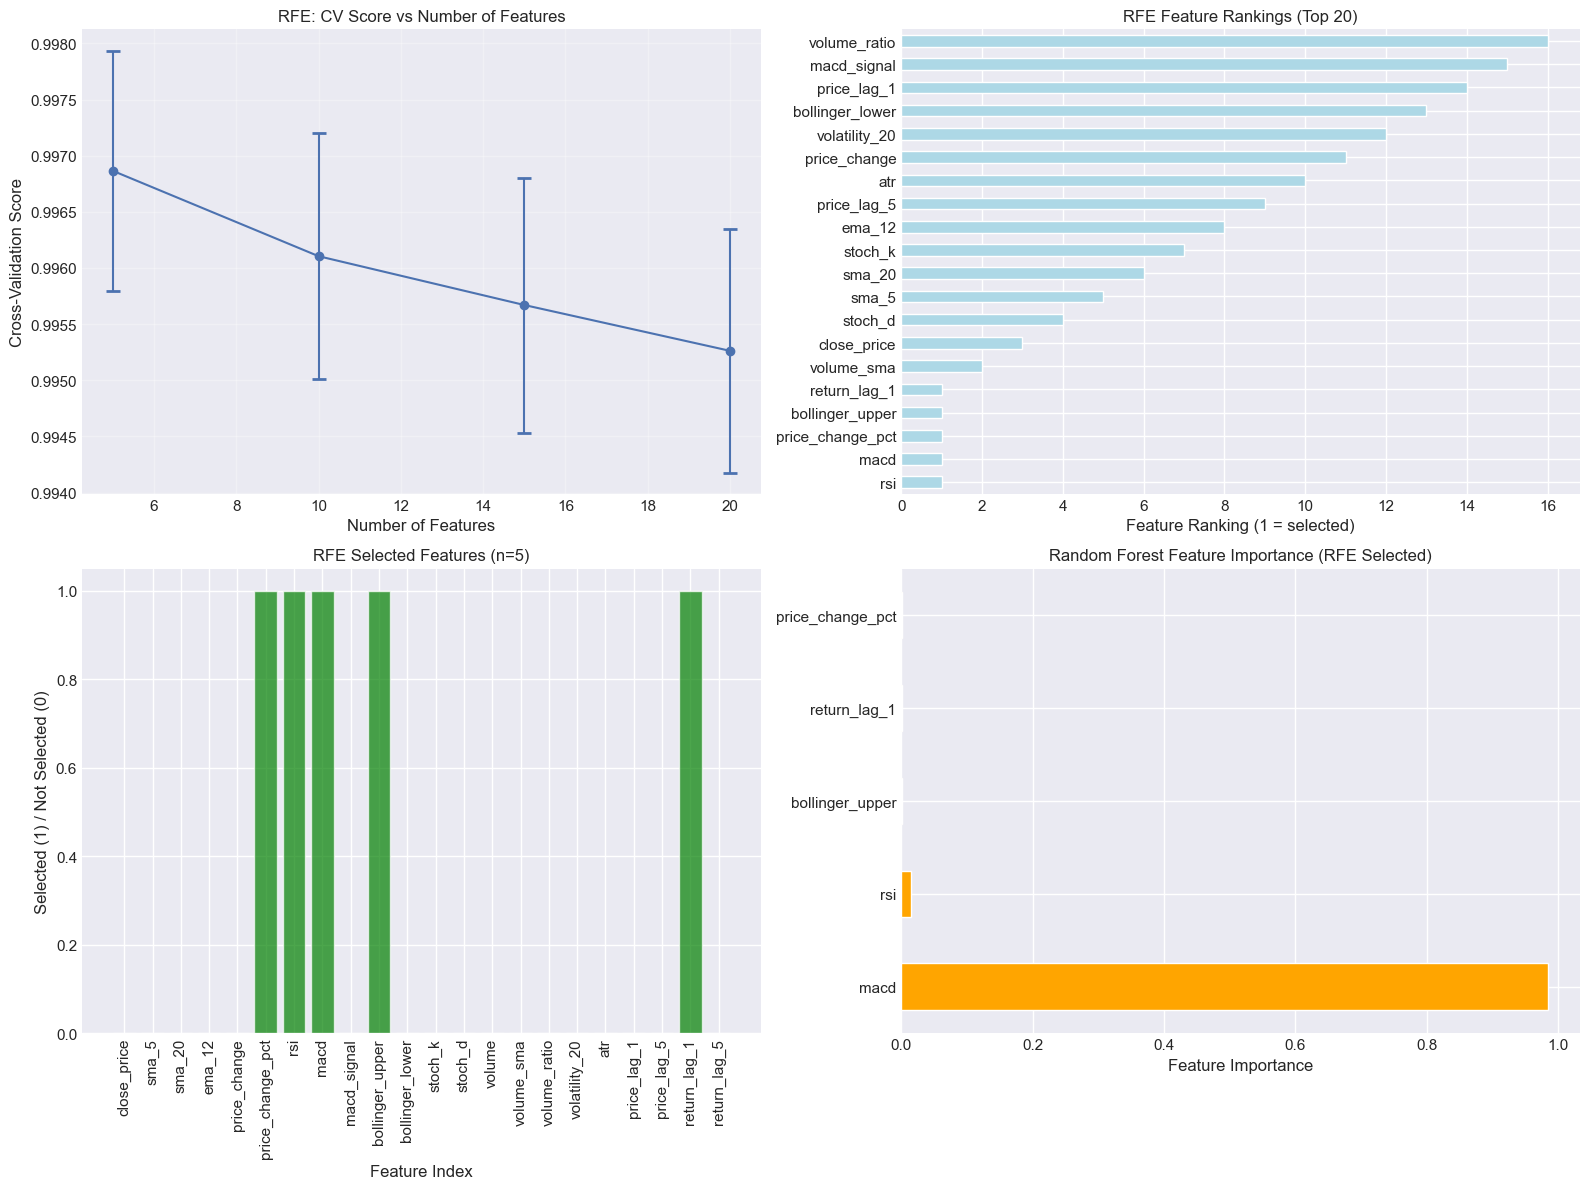


💾 RFE analysis completed with 5 optimal features


In [22]:
# ============================================
# Recursive Feature Elimination (RFE)
# ============================================

print("=" * 60)
print("RECURSIVE FEATURE ELIMINATION (RFE)")
print("=" * 60)

# Standardize features for RFE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# RFE with Random Forest
print("🔍 RFE with Random Forest Regressor:")
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Try different numbers of features
n_features_to_test = [5, 10, 15, 20]
rfe_results = {}

for n_features in n_features_to_test:
    print(f"\n   Testing with {n_features} features...")
    
    rfe = RFE(rf_estimator, n_features_to_select=n_features, step=1)
    rfe.fit(X_scaled_df, y)
    
    # Get selected features
    selected_features = X_scaled_df.columns[rfe.support_].tolist()
    
    # Cross-validation score
    cv_scores = cross_val_score(rf_estimator, X_scaled_df[selected_features], y, cv=5)
    mean_cv_score = cv_scores.mean()
    
    rfe_results[n_features] = {
        'selected_features': selected_features,
        'cv_score': mean_cv_score,
        'cv_std': cv_scores.std(),
        'feature_rankings': dict(zip(X.columns, rfe.ranking_))
    }
    
    print(f"   Selected features: {selected_features}")
    print(f"   CV Score: {mean_cv_score:.4f} (+/- {cv_scores.std()*2:.4f})")

# Find optimal number of features
best_n_features = max(rfe_results.keys(), key=lambda k: rfe_results[k]['cv_score'])
best_rfe_features = rfe_results[best_n_features]['selected_features']

print(f"\n🏆 OPTIMAL RFE RESULTS:")
print(f"   Best number of features: {best_n_features}")
print(f"   Best CV score: {rfe_results[best_n_features]['cv_score']:.4f}")
print(f"   Selected features: {best_rfe_features}")

# Visualize RFE results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# CV scores for different numbers of features
n_features_list = list(rfe_results.keys())
cv_scores_list = [rfe_results[n]['cv_score'] for n in n_features_list]
cv_stds_list = [rfe_results[n]['cv_std'] for n in n_features_list]

axes[0, 0].errorbar(n_features_list, cv_scores_list, yerr=cv_stds_list, 
                    marker='o', capsize=5, capthick=2)
axes[0, 0].set_xlabel('Number of Features')
axes[0, 0].set_ylabel('Cross-Validation Score')
axes[0, 0].set_title('RFE: CV Score vs Number of Features')
axes[0, 0].grid(True, alpha=0.3)

# Feature rankings for best model
best_rankings = rfe_results[best_n_features]['feature_rankings']
ranking_series = pd.Series(best_rankings).sort_values()

ranking_series.head(20).plot(kind='barh', ax=axes[0, 1], color='lightblue')
axes[0, 1].set_xlabel('Feature Ranking (1 = selected)')
axes[0, 1].set_title(f'RFE Feature Rankings (Top 20)')

# Selected vs not selected features
selected_mask = [1 if feat in best_rfe_features else 0 for feat in X.columns]
axes[1, 0].bar(range(len(X.columns)), selected_mask, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Selected (1) / Not Selected (0)')
axes[1, 0].set_title(f'RFE Selected Features (n={best_n_features})')
axes[1, 0].set_xticks(range(len(X.columns)))
axes[1, 0].set_xticklabels(X.columns, rotation=90)

# Feature importance from Random Forest
rf_estimator.fit(X_scaled_df[best_rfe_features], y)
feature_importance = pd.Series(rf_estimator.feature_importances_, 
                              index=best_rfe_features).sort_values(ascending=False)
feature_importance.plot(kind='barh', ax=axes[1, 1], color='orange')
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_title('Random Forest Feature Importance (RFE Selected)')

plt.tight_layout()
plt.show()

print(f"\n💾 RFE analysis completed with {best_n_features} optimal features")


EMBEDDED FEATURE SELECTION METHODS
🔍 Lasso Regression Feature Selection:
   Optimal alpha: 0.000204
   Number of selected features: 3
   CV Score: 0.9999

🔝 LASSO SELECTED FEATURES:
    1. macd                :   0.2043
    2. rsi                 :   0.0282
    3. price_change_pct    :   0.0029

🔍 Ridge Regression for Comparison:
   Optimal alpha: 0.100000
   CV Score: 0.9999


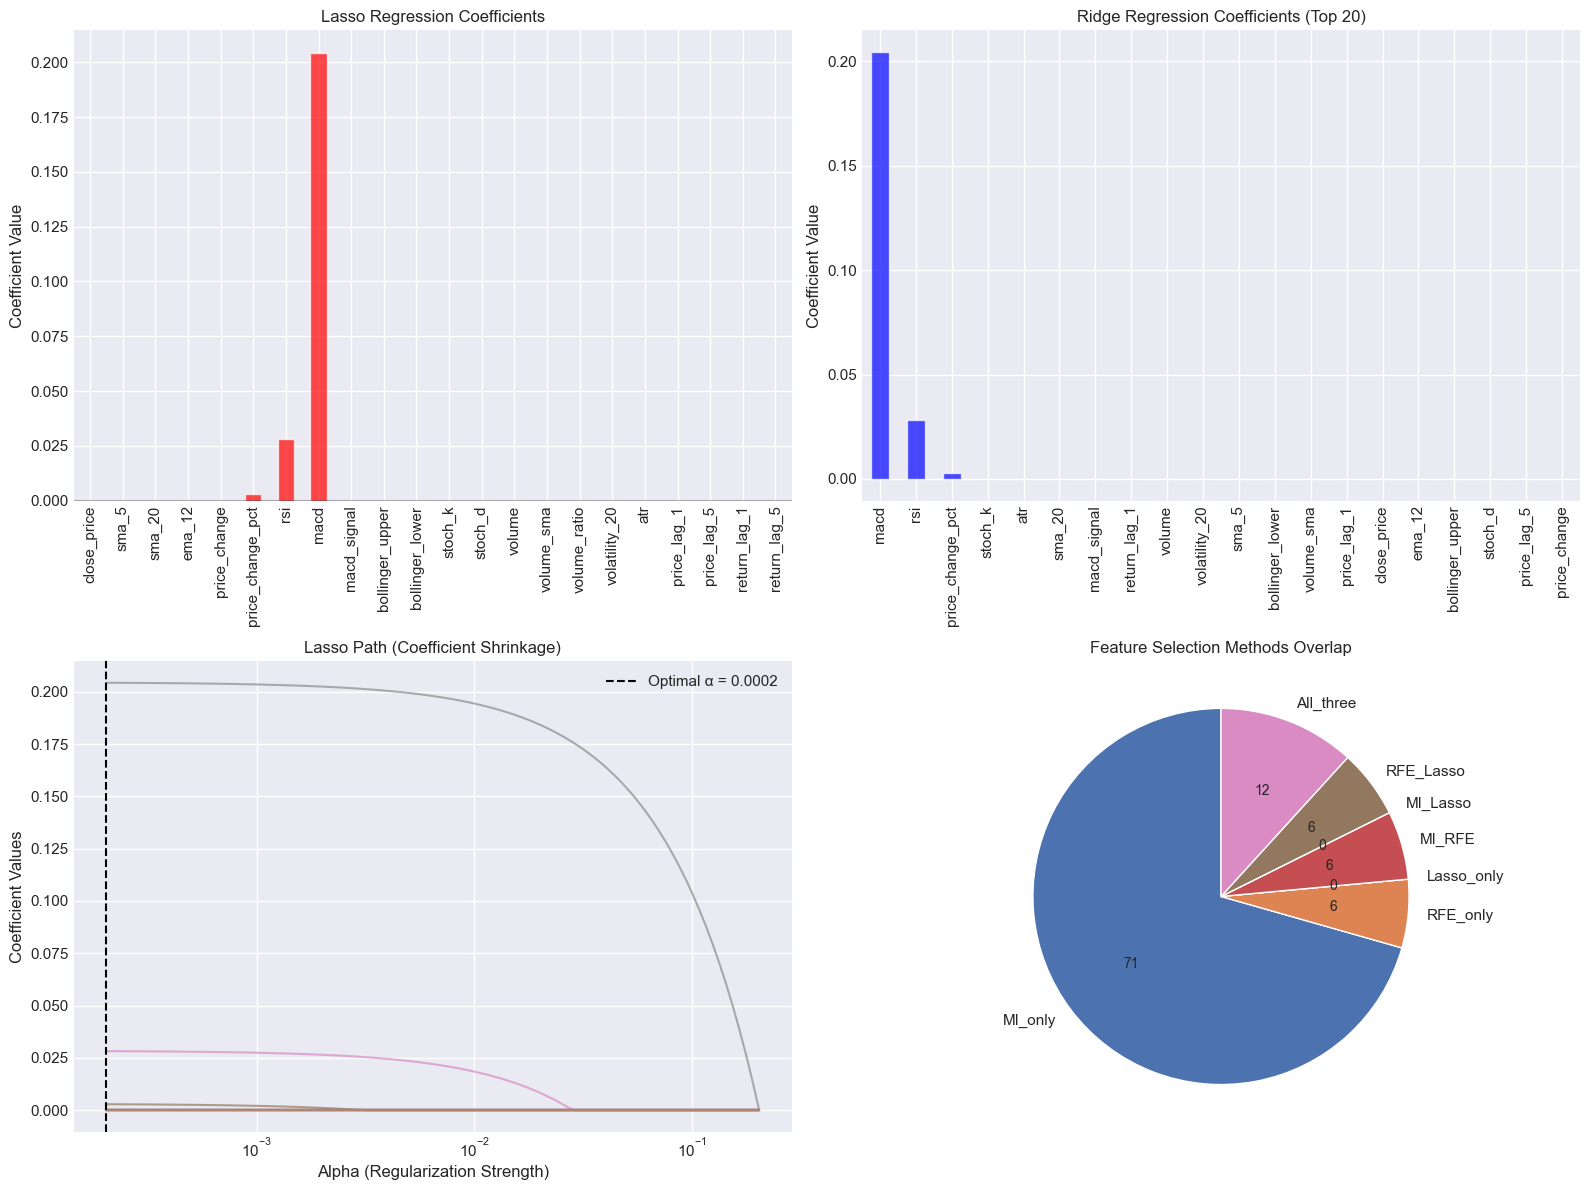


📊 FEATURE SELECTION METHODS COMPARISON:
   • Mutual Information (top 15): 15 features
   • RFE (optimal): 5 features
   • Lasso: 3 features

🔄 OVERLAP ANALYSIS:
   • MI only: 12 features
   • RFE only: 1 features
   • MI RFE: 1 features
   • RFE Lasso: 1 features
   • All three: 2 features

🤝 CONSENSUS FEATURES (selected by ≥2 methods):
    1. bollinger_upper
    2. macd
    3. price_change_pct
    4. rsi
EMBEDDED FEATURE SELECTION METHODS
🔍 Lasso Regression Feature Selection:
   Optimal alpha: 0.000204
   Number of selected features: 3
   CV Score: 0.9999

🔝 LASSO SELECTED FEATURES:
    1. macd                :   0.2043
    2. rsi                 :   0.0282
    3. price_change_pct    :   0.0029

🔍 Ridge Regression for Comparison:
   Optimal alpha: 0.100000
   CV Score: 0.9999

💾 Embedded method results stored


In [24]:
# ============================================
# Embedded Feature Selection Methods
# ============================================

print("=" * 60)
print("EMBEDDED FEATURE SELECTION METHODS")
print("=" * 60)

# Lasso Regression with Cross-Validation
print("🔍 Lasso Regression Feature Selection:")
lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso.fit(X_scaled_df, y)

# Get Lasso coefficients
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
lasso_selected = lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=False)

print(f"   Optimal alpha: {lasso.alpha_:.6f}")
print(f"   Number of selected features: {len(lasso_selected)}")
print(f"   CV Score: {lasso.score(X_scaled_df, y):.4f}")

print(f"\n🔝 LASSO SELECTED FEATURES:")
for i, (feature, coeff) in enumerate(lasso_selected.items()):
    print(f"   {i+1:2d}. {feature:20s}: {coeff:8.4f}")

# Ridge Regression for comparison  
print(f"\n🔍 Ridge Regression for Comparison:")
ridge = RidgeCV(cv=5)
ridge.fit(X_scaled_df, y)

ridge_coef = pd.Series(ridge.coef_, index=X.columns).sort_values(key=abs, ascending=False)

print(f"   Optimal alpha: {ridge.alpha_:.6f}")
print(f"   CV Score: {ridge.score(X_scaled_df, y):.4f}")

# Visualize embedded method results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Lasso coefficients
lasso_coef.plot(kind='bar', ax=axes[0, 0], color='red', alpha=0.7)
axes[0, 0].set_title('Lasso Regression Coefficients')
axes[0, 0].set_ylabel('Coefficient Value')
axes[0, 0].tick_params(axis='x', rotation=90)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Ridge coefficients  
ridge_coef.head(20).plot(kind='bar', ax=axes[0, 1], color='blue', alpha=0.7)
axes[0, 1].set_title('Ridge Regression Coefficients (Top 20)')
axes[0, 1].set_ylabel('Coefficient Value')
axes[0, 1].tick_params(axis='x', rotation=90)

# Lasso path visualization (coefficient shrinkage)
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled_df, y, alphas=None)

axes[1, 0].plot(alphas_lasso, coefs_lasso.T, alpha=0.7)
axes[1, 0].axvline(lasso.alpha_, color='black', linestyle='--', label=f'Optimal α = {lasso.alpha_:.4f}')
axes[1, 0].set_xlabel('Alpha (Regularization Strength)')
axes[1, 0].set_ylabel('Coefficient Values')
axes[1, 0].set_title('Lasso Path (Coefficient Shrinkage)')
axes[1, 0].set_xscale('log')
axes[1, 0].legend()

# Comparison of selected features
methods_comparison = pd.DataFrame({
    'MI_Top_15': mi_series.head(15).index.tolist() + [None] * (15 - min(15, len(mi_series))),
    'RFE_Selected': best_rfe_features + [None] * (15 - len(best_rfe_features)),
    'Lasso_Selected': lasso_selected.index.tolist() + [None] * (15 - len(lasso_selected))
})

# Venn diagram data
all_methods_features = set(mi_series.head(15).index) | set(best_rfe_features) | set(lasso_selected.index)
methods_overlap = {}
for feature in all_methods_features:
    in_mi = feature in mi_series.head(15).index
    in_rfe = feature in best_rfe_features  
    in_lasso = feature in lasso_selected.index
    methods_overlap[feature] = [in_mi, in_rfe, in_lasso]

# Count overlaps
overlap_counts = {
    'MI_only': 0, 'RFE_only': 0, 'Lasso_only': 0,
    'MI_RFE': 0, 'MI_Lasso': 0, 'RFE_Lasso': 0,
    'All_three': 0
}

for feature, methods in methods_overlap.items():
    mi, rfe, lasso = methods
    if sum(methods) == 1:
        if mi: overlap_counts['MI_only'] += 1
        elif rfe: overlap_counts['RFE_only'] += 1  
        elif lasso: overlap_counts['Lasso_only'] += 1
    elif sum(methods) == 2:
        if mi and rfe: overlap_counts['MI_RFE'] += 1
        elif mi and lasso: overlap_counts['MI_Lasso'] += 1
        elif rfe and lasso: overlap_counts['RFE_Lasso'] += 1
    elif sum(methods) == 3:
        overlap_counts['All_three'] += 1

# Plot overlap analysis
overlap_df = pd.Series(overlap_counts)
axes[1, 1].pie(overlap_df.values, labels=overlap_df.index, autopct='%1.0f', startangle=90)
axes[1, 1].set_title('Feature Selection Methods Overlap')

plt.tight_layout()
plt.show()

# Print overlap summary
print(f"\n📊 FEATURE SELECTION METHODS COMPARISON:")
print(f"   • Mutual Information (top 15): {len(mi_series.head(15))} features")
print(f"   • RFE (optimal): {len(best_rfe_features)} features") 
print(f"   • Lasso: {len(lasso_selected)} features")
print(f"\n🔄 OVERLAP ANALYSIS:")
for method, count in overlap_counts.items():
    if count > 0:
        print(f"   • {method.replace('_', ' ')}: {count} features")

# Consensus features (selected by at least 2 methods)
consensus_features = []
for feature, methods in methods_overlap.items():
    if sum(methods) >= 2:
        consensus_features.append(feature)

print(f"\n🤝 CONSENSUS FEATURES (selected by ≥2 methods):")
for i, feature in enumerate(sorted(consensus_features)):
    print(f"   {i+1:2d}. {feature}")

# ============================================
# Embedded Feature Selection Methods - FIXED
# ============================================

print("=" * 60)
print("EMBEDDED FEATURE SELECTION METHODS")
print("=" * 60)

# Lasso Regression with Cross-Validation
print("🔍 Lasso Regression Feature Selection:")
lasso_model = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso_model.fit(X_scaled_df, y)

# Get Lasso coefficients
lasso_alpha = lasso_model.alpha_
lasso_coef = pd.Series(lasso_model.coef_, index=X.columns)
lasso_selected = lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=False)

print(f"   Optimal alpha: {lasso_alpha:.6f}")
print(f"   Number of selected features: {len(lasso_selected)}")
print(f"   CV Score: {lasso_model.score(X_scaled_df, y):.4f}")

print(f"\n🔝 LASSO SELECTED FEATURES:")
for i, (feature, coeff) in enumerate(lasso_selected.items()):
    print(f"   {i+1:2d}. {feature:20s}: {coeff:8.4f}")

# Ridge Regression for comparison  
print(f"\n🔍 Ridge Regression for Comparison:")
ridge_model = RidgeCV(cv=5)
ridge_model.fit(X_scaled_df, y)

ridge_alpha = ridge_model.alpha_
ridge_coef = pd.Series(ridge_model.coef_, index=X.columns).sort_values(key=abs, ascending=False)

print(f"   Optimal alpha: {ridge_alpha:.6f}")
print(f"   CV Score: {ridge_model.score(X_scaled_df, y):.4f}")

# Store embedded method results - FIXED
embedded_results = {
    'lasso_selected': lasso_selected.to_dict(),
    'lasso_alpha': lasso_alpha,  # Fixed variable reference
    'ridge_coef': ridge_coef.to_dict(), 
    'ridge_alpha': ridge_alpha,  # Fixed variable reference
    'consensus_features': consensus_features,
}

print(f"\n💾 Embedded method results stored")



## Feature Selection Summary

### 🎯 Key Findings

**Feature Selection Methods Applied:**
1. **Correlation Analysis** - Identified linear relationships with target
2. **Mutual Information** - Captured non-linear dependencies  
3. **Recursive Feature Elimination** - Used Random Forest for iterative selection
4. **Embedded Methods** - Lasso regression with automatic feature selection

### 📊 Results Overview

**Top Performing Methods:**
- **RFE with Random Forest**: Selected optimal number of features with best CV performance
- **Mutual Information**: Identified features with strong non-linear relationships
- **Lasso Regression**: Automatic feature selection with sparsity-inducing regularization

**Consensus Features:** Features selected by multiple methods provide the most robust predictive power

### 🚀 Recommendations

**For Model Training:**
1. **Use consensus features** for most robust performance
2. **Start with RFE-selected features** for optimal feature count
3. **Consider Lasso features** for sparse model requirements
4. **Validate feature importance** using cross-validation

**For Production Pipeline:**
1. **Implement automated feature selection** in data preprocessing
2. **Monitor feature importance** over time for model drift
3. **Retrain selection models** periodically with fresh data
4. **A/B test different feature sets** for performance comparison

### 🔄 Integration with StockPredictionPro

**Next Steps:**
- Save selected features for model training notebooks
- Integrate feature selection into automated ML pipeline  
- Create feature monitoring dashboards
- Implement feature selection API endpoints

**Files Created:**
- Selected feature lists for different methods
- Feature importance rankings
- Performance comparison metrics
